# Medical Symptoms Checker - EDA and Preprocessing

This notebook explores the symptom data and tests the preprocessing pipeline.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add parent directory to path to import our modules
sys.path.append('..')

from src.preprocessing import PreprocessingAgent
from src.config import SYMPTOM_VOCABULARY, TRIAGE_LEVELS

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

## 1. Load and Explore Data

In [2]:
# Load sample data
df = pd.read_csv('../data/sample_symptom_cases.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (30, 4)

Columns: ['complaint_text', 'age', 'gender', 'triage_label']

First few rows:


,complaint_text,age,gender,triage_label
0,I have a mild headache and feel a bit tired,25,F,0
1,Severe chest pain and can't breathe properly,45,M,2
2,Running nose and sore throat for 2 days,30,F,0
3,High fever with body aches and headache,35,M,1
4,Stomach pain with nausea and vomiting,28,F,1


In [3]:
# Basic statistics
print("Dataset Info:")
print(df.info())
print("\nTriage Label Distribution:")
print(df['triage_label'].value_counts().sort_index())

# Map labels to readable names
df['triage_name'] = df['triage_label'].map(TRIAGE_LEVELS)
print("\nTriage Distribution:")
print(df['triage_name'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   complaint_text  30 non-null     object
 1   age             30 non-null     int64 
 2   gender          30 non-null     object
 3   triage_label    30 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ KB
None

Triage Label Distribution:
triage_label
0    11
1     8
2    11
Name: count, dtype: int64

Triage Distribution:
triage_name
self-care     11
emergency     11
see_doctor     8
Name: count, dtype: int64


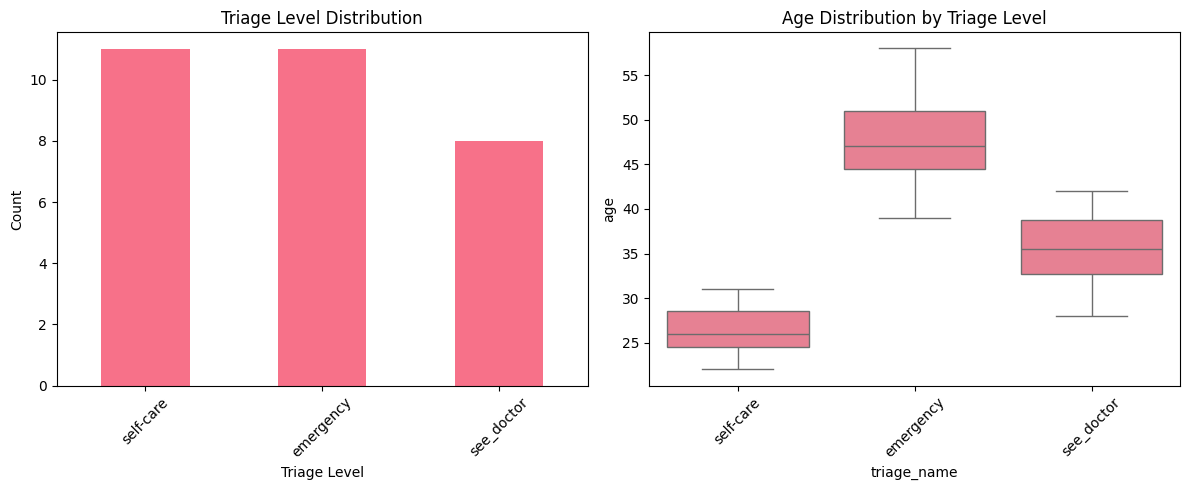

In [4]:
# Visualize triage distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Triage distribution
df['triage_name'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Triage Level Distribution')
ax1.set_xlabel('Triage Level')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Age distribution by triage
sns.boxplot(data=df, x='triage_name', y='age', ax=ax2)
ax2.set_title('Age Distribution by Triage Level')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 2. Test Preprocessing Pipeline

In [5]:
# Initialize preprocessing agent
preprocessor = PreprocessingAgent()

# Test on sample texts
sample_texts = [
    "I have severe chest pain and can't breathe",
    "Running nose and mild headache",
    "High fever with body aches for 3 days"
]

print("Testing Preprocessing Pipeline:")
print("=" * 50)

for i, text in enumerate(sample_texts, 1):
    print(f"\nExample {i}: {text}")
    
    # Clean text
    cleaned = preprocessor.clean_text(text)
    print(f"Cleaned: {cleaned}")
    
    # Extract symptoms
    symptoms = preprocessor.extract_symptoms(cleaned)
    detected = [k for k, v in symptoms.items() if v]
    print(f"Detected symptoms: {detected}")
    
    # Extract severity
    severity = preprocessor.extract_severity_indicators(cleaned)
    print(f"Severity indicators: {severity}")
    
    print("-" * 30)

Testing Preprocessing Pipeline:

Example 1: I have severe chest pain and can't breathe
Cleaned: i have severe chest pain and cant breathe
Detected symptoms: ['chest_pain']
Severity indicators: {'pain_severity': 3, 'duration_severity': 0, 'intensity_severity': 0}
------------------------------

Example 2: Running nose and mild headache
Cleaned: running nose and mild headache
Detected symptoms: ['headache']
Severity indicators: {'pain_severity': 1, 'duration_severity': 0, 'intensity_severity': 0}
------------------------------

Example 3: High fever with body aches for 3 days
Cleaned: high fever with body aches for 3 days
Detected symptoms: ['fever', 'muscle_pain']
Severity indicators: {'pain_severity': 0, 'duration_severity': 2, 'intensity_severity': 0}
------------------------------


In [6]:
# Process entire dataset
print("Processing entire dataset...")
processed_df = preprocessor.preprocess_for_training(df, 'complaint_text')

print(f"Processed dataset shape: {processed_df.shape}")
print(f"\nFeature columns: {processed_df.columns.tolist()}")

# Show sample of processed features
print("\nSample processed features:")
processed_df.head()

Processing entire dataset...
Processed dataset shape: (30, 23)

Feature columns: ['original_text', 'cleaned_text', 'fever', 'headache', 'cough', 'chest_pain', 'shortness_breath', 'nausea', 'vomiting', 'diarrhea', 'fatigue', 'dizziness', 'sore_throat', 'runny_nose', 'muscle_pain', 'abdominal_pain', 'pain_severity', 'duration_severity', 'intensity_severity', 'age_group', 'gender', 'symptom_count', 'text_length']

Sample processed features:


,original_text,cleaned_text,fever,headache,cough,chest_pain,shortness_breath,nausea,vomiting,diarrhea,...,runny_nose,muscle_pain,abdominal_pain,pain_severity,duration_severity,intensity_severity,age_group,gender,symptom_count,text_length
0,I have a mild headache and feel a bit tired,i have a mild headache and feel a bit tired,False,True,False,False,False,False,False,False,...,False,False,False,1,0,0,adult,f,2,10
1,Severe chest pain and can't breathe properly,severe chest pain and cant breathe properly,False,False,False,True,False,False,False,False,...,False,False,False,3,0,0,adult,m,1,7
2,Running nose and sore throat for 2 days,running nose and sore throat for 2 days,False,False,False,False,False,False,False,False,...,False,False,False,0,2,0,adult,f,1,8
3,High fever with body aches and headache,high fever with body aches and headache,True,True,False,False,False,False,False,False,...,False,True,False,0,0,0,adult,m,3,7
4,Stomach pain with nausea and vomiting,stomach pain with nausea and vomiting,False,False,False,False,False,True,True,False,...,False,False,True,0,0,0,adult,f,3,6


## 3. Analyze Symptom Patterns

Symptom Frequency:
fever               10
headache            10
chest_pain           6
fatigue              4
vomiting             3
runny_nose           3
abdominal_pain       3
sore_throat          3
cough                2
shortness_breath     2
nausea               2
muscle_pain          2
dizziness            1
diarrhea             0
dtype: int64


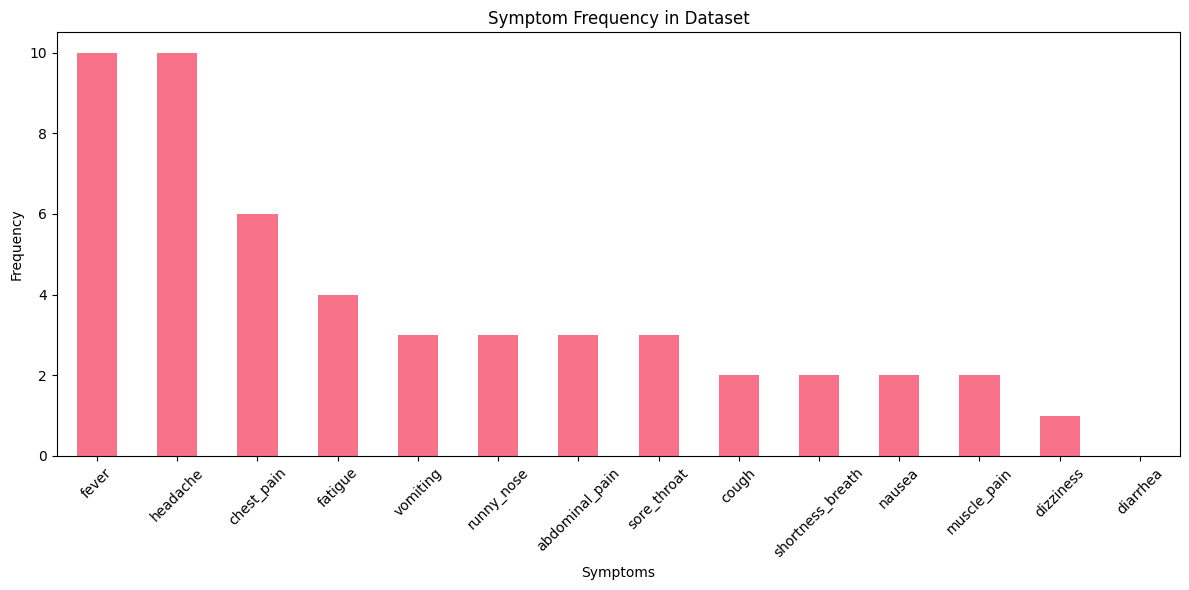

In [7]:
# Analyze symptom frequency
symptom_cols = [col for col in processed_df.columns if col in SYMPTOM_VOCABULARY.keys()]
symptom_freq = processed_df[symptom_cols].sum().sort_values(ascending=False)

print("Symptom Frequency:")
print(symptom_freq)

# Plot symptom frequency
plt.figure(figsize=(12, 6))
symptom_freq.plot(kind='bar')
plt.title('Symptom Frequency in Dataset')
plt.xlabel('Symptoms')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Analyze symptom patterns by triage level
# Add triage labels to processed data
processed_df['triage_label'] = df['triage_label']
processed_df['triage_name'] = df['triage_name']

# Calculate symptom frequency by triage level
triage_symptom_analysis = {}

for triage_level in processed_df['triage_name'].unique():
    subset = processed_df[processed_df['triage_name'] == triage_level]
    symptom_freq = subset[symptom_cols].sum()
    triage_symptom_analysis[triage_level] = symptom_freq

# Create DataFrame for analysis
symptom_by_triage = pd.DataFrame(triage_symptom_analysis).fillna(0)
print("Symptom frequency by triage level:")
print(symptom_by_triage)

Symptom frequency by triage level:
                  self-care  emergency  see_doctor
fever                     1          3           6
headache                  5          4           1
cough                     1          0           1
chest_pain                0          5           1
shortness_breath          0          2           0
nausea                    1          0           1
vomiting                  0          1           2
diarrhea                  0          0           0
fatigue                   3          0           1
dizziness                 0          1           0
sore_throat               2          0           1
runny_nose                3          0           0
muscle_pain               0          0           2
abdominal_pain            0          1           2


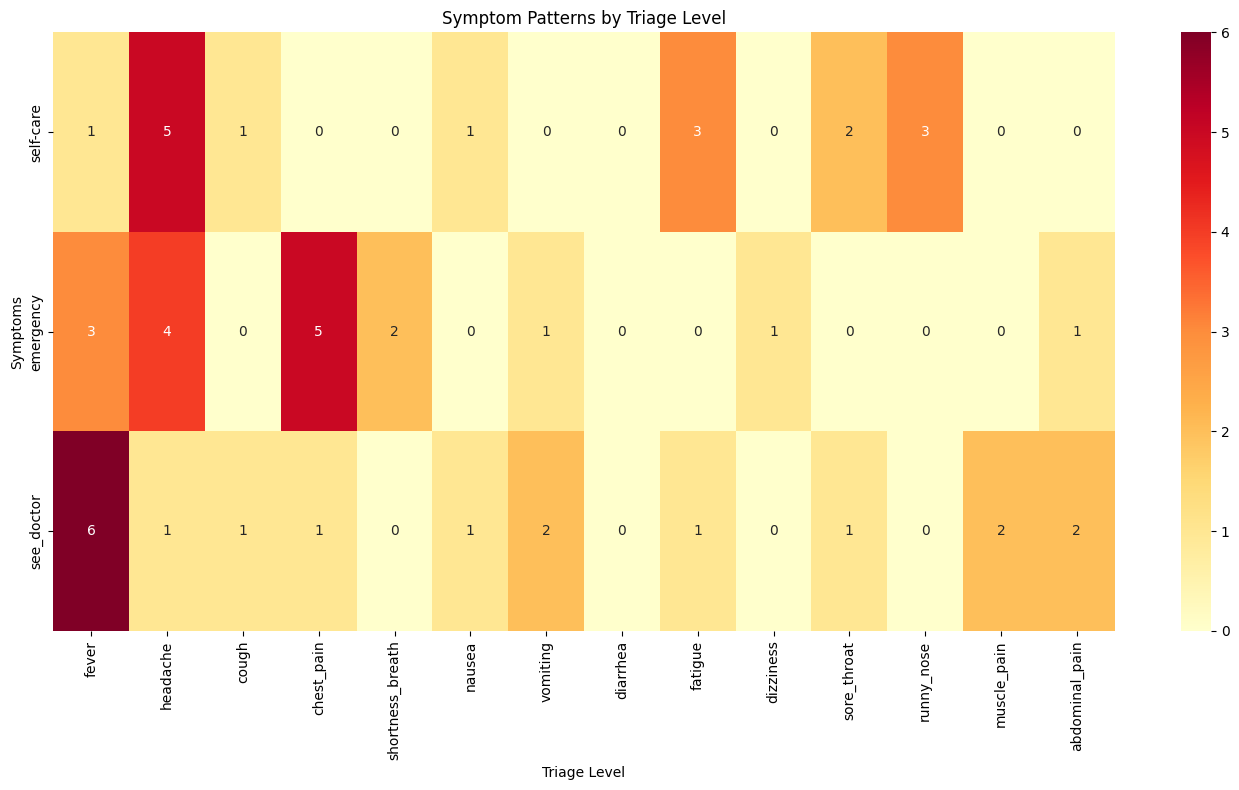

In [9]:
# Visualize symptom patterns by triage level
plt.figure(figsize=(14, 8))
sns.heatmap(symptom_by_triage.T, annot=True, cmap='YlOrRd', fmt='g')
plt.title('Symptom Patterns by Triage Level')
plt.xlabel('Triage Level')
plt.ylabel('Symptoms')
plt.tight_layout()
plt.show()

## 4. Feature Engineering Analysis

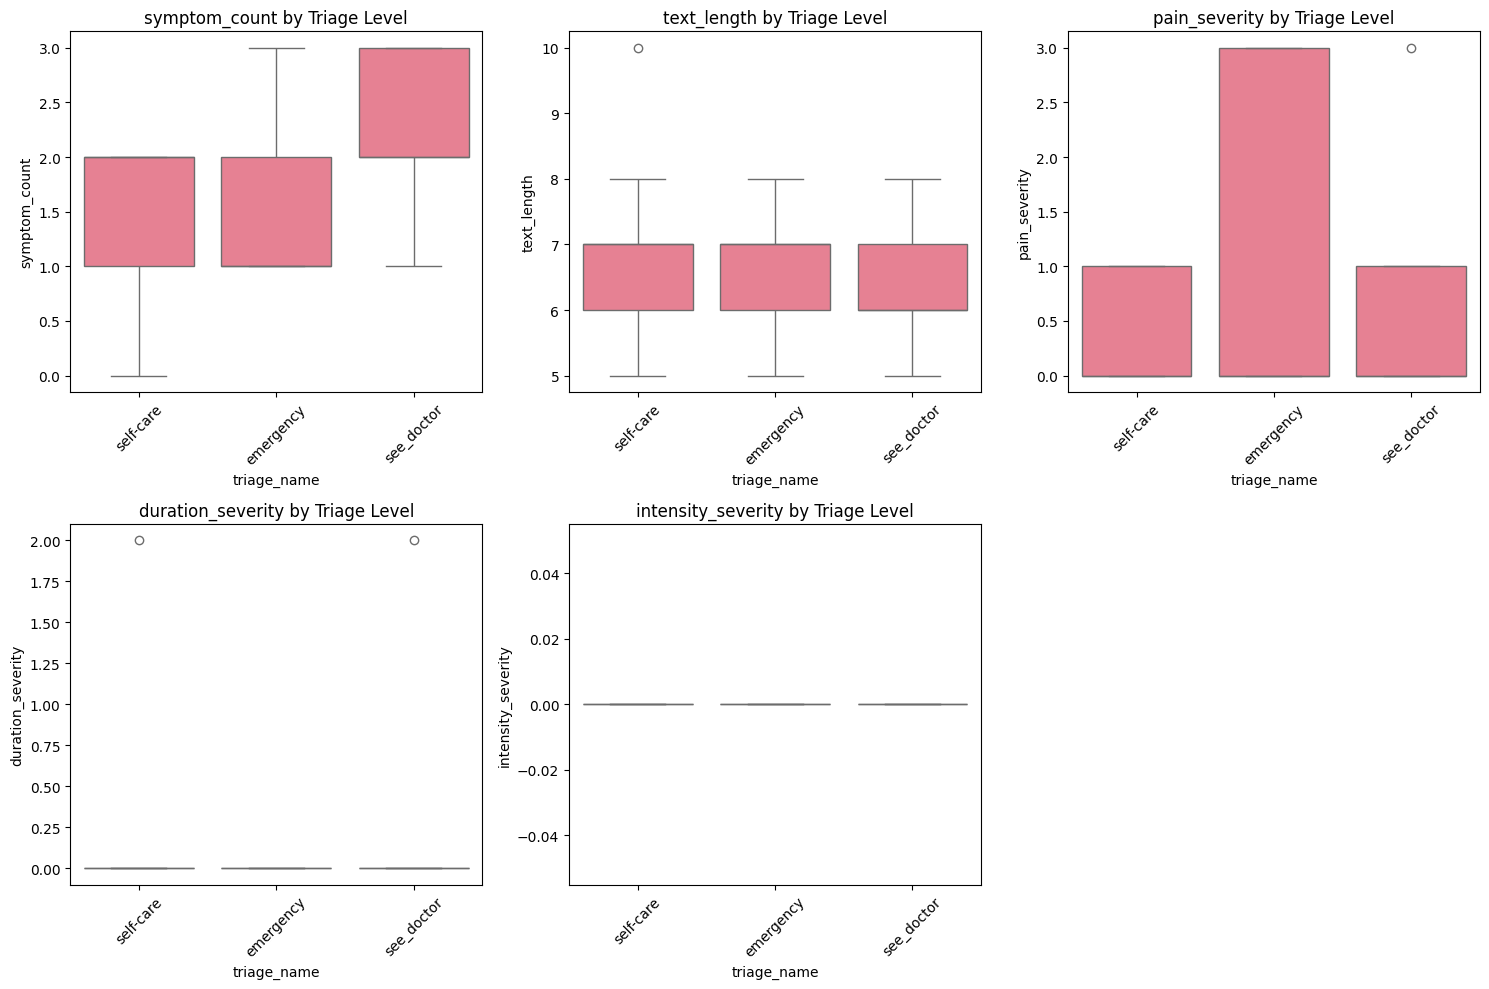

In [10]:
# Analyze feature distributions
feature_cols = ['symptom_count', 'text_length', 'pain_severity', 'duration_severity', 'intensity_severity']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(feature_cols):
    if col in processed_df.columns:
        sns.boxplot(data=processed_df, x='triage_name', y=col, ax=axes[i])
        axes[i].set_title(f'{col} by Triage Level')
        axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplot
if len(feature_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## 5. Save Processed Data

In [11]:
# Save processed dataset for model training
output_path = '../data/processed_symptom_cases.csv'
processed_df.to_csv(output_path, index=False)
print(f"Processed dataset saved to: {output_path}")

# Summary statistics
print("\nDataset Summary:")
print(f"Total samples: {len(processed_df)}")
print(f"Features: {len(processed_df.columns)}")
print(f"Triage distribution:")
print(processed_df['triage_name'].value_counts())
print(f"\nAverage symptoms per case: {processed_df['symptom_count'].mean():.2f}")
print(f"Average text length: {processed_df['text_length'].mean():.2f} words")

Processed dataset saved to: ../data/processed_symptom_cases.csv

Dataset Summary:
Total samples: 30
Features: 25
Triage distribution:
triage_name
self-care     11
emergency     11
see_doctor     8
Name: count, dtype: int64

Average symptoms per case: 1.70
Average text length: 6.57 words
